### We combine the `nsa_z001_002` and `nsa_z002_004` UDG sample. Then we select those biggest and brightest galaxies.

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress

import astropy.units as u
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

import pickle


Bad key savefig.frameon in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc

In [37]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=15)

In [38]:
udg_cat = vstack([Table.read(
    '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z002_004/udg_z002_004_spergel_after_viz.fits'),
                  Table.read(
    '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_002/udg_z001_002_spergel_after_viz.fits')])
# SB_avg_g-band > 24.3

In [39]:
udg_cat[udg_cat['viz-id'] == 75619]

ra,dec,a_image,b_image,theta_image,ellipticity,mag_auto_g,mag_auto_r,mag_auto_i,flux_radius_ave_g,flux_radius_ave_i,mu_ave_g,mu_ave_i,acorr_ratio,g-i,g-r,A_g,A_r,A_i,tract,patch,synth_id,viz-id,is_candy,is_galaxy,is_tidal,is_outskirts,is_cirrus,is_junk,num_votes,good_votes,bad_votes,host_name,host_z,host_ang_diam_dist,host_stellar_mass,host_halo_mass,host_r_vir,host_r_vir_ang,host_300kpc_ang,host_nvotes,host_spiral,host_elliptical,host_uncertain,host_RA,host_DEC,cutout_size,prefix,radius,image_flag [5],psf_flag [5],ID,flux [4],mag [4],flux_circ [4],flux_ellip [4],SB_0 [4],SB_eff_circ [4],SB_eff_ellip [4],SB_eff_avg [4],xc_cen,yc_cen,xc_sym,yc_sym,ell_cen,ell_sym,PA_cen,PA_sym,rhalf_circ,rhalf_ellip,rhalf_circularized,rhalf_spergel,r20,r50,r80,Gini,M20,"F(G,M20)","S(G,M20)",C,A,A_outer,A_shape,S,sersic_n,sersic_rhalf,sersic_ell,sersic_PA,sersic_xc,sersic_yc,sersic_amp,flag,flag_sersic,abs_mag [4],SB_eff_avg_g,rhalf_circularized_phys,log_m_star,RA,DEC
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,,,,,,,,,,,,,,arcmin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,bytes3,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,bytes19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes66,float64,bool,bool,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
16.8497991,-0.6801767,26.261,19.54,81.46,0.256,19.1249,18.5118,18.1349,6.512856000000001,7.458108,24.486990124953035,23.825105739186924,1.058973012472167,0.7741106854512696,0.5069379635138274,0.14847788106135545,0.1052158445751826,0.07508856651262487,9237,"1,4",-1,75619,2,0,0,0,0,0,2,2,0,J010709.16-003718.2,0.01770278625190258,76.66627716215355,10.693181365260706,12.275172233581543,322.38221593624473,0.2409291494811206,0.22420202254156057,28.0,0.0,1.0,0.0,16.78818385473689,-0.6217567854398885,1.0,/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/z001_002/nsa_75619,1.0,True .. True,True .. True,75619,1232.5649725631129 .. 3049.188445371939,19.272975445883603 .. 18.289539336547875,1207.4778331643079 .. 2987.1264711271256,1207.2896835607876 .. 2986.661016072158,23.724984655193683 .. 22.741548545857952,25.249900711798755 .. 24.266464602463024,25.203125090454463 .. 24.219688981118736,24.565291468880446 .. 23.58185535954472,356.5690002321794,358.26788326488764,356.60066347210386,358.2232967668939,0.279950908201296,0.2799498902209827,1.2647489515070987,1.2647522212569005,27.17612460751825,31.550650789993703,26.77254654404421,27.16839536895909,13.587246918960657,26.93697121595497,46.645723542956425,0.48114546897151267,-1.7731787724627914,-0.3495170392742981,-0.09713783509053048,2.678401830805181,0.0014347749180925486,0.004892869900281523,0.6943944083280187,0.009277369460089845,0.9194696776038419,32.637438211326106,0.32718239582152503,1.2910243997359698,356.4900564805105,358.31338804812924,0.14795128951717532,0.0,0.0,-15.150046428426238 .. -16.133482537761964,24.565291468880446,1.6964931255446856,8.26494871128988,16.8497991,-0.6801767


In [41]:
# SB and R_e
SB_g_meas = udg_cat['SB_eff_avg'][:, 0].data
R_e = udg_cat['rhalf_spergel'].data * 0.168

# Correct for the measurement error
with open('./Catalog/completeness/Re_meas_err.pkl', 'rb') as f:
    (f_med, f_std) = pickle.load(f)
R_e += f_med(SB_g_meas)
R_e_std = f_std(SB_g_meas)

ang_diam_dist = udg_cat['host_ang_diam_dist'].data # not consider peculiar motion
R_e_phys = R_e / 206265 * ang_diam_dist * 1000 # in kpc
R_e_phys_std = R_e_std / 206265 * ang_diam_dist * 1000 # in kpc

with open('./Catalog/completeness/SB_meas_err.pkl', 'rb') as f:
    (f_med, f_std) = pickle.load(f)

SB_g = SB_g_meas + f_med(SB_g_meas)
SB_g_std = f_std(SB_g_meas)

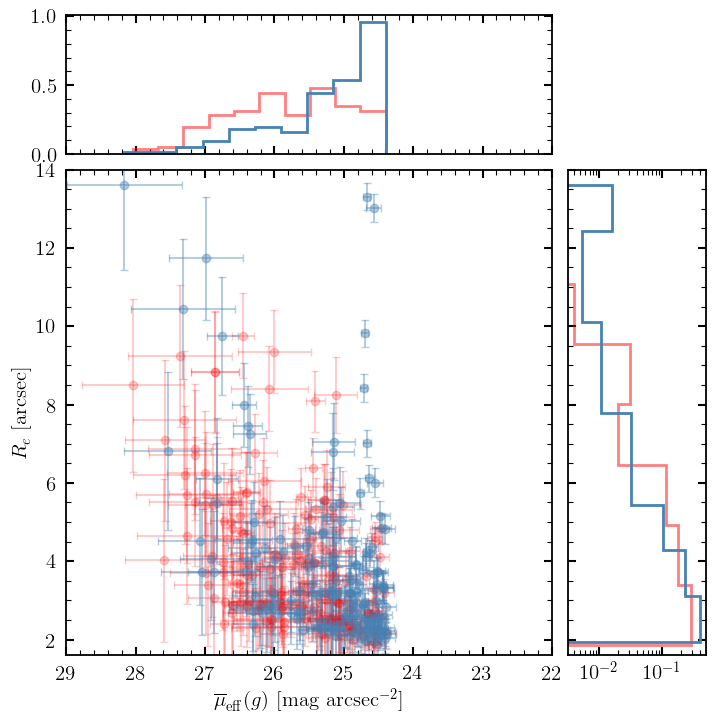

In [6]:
# start with a square Figure
fig = plt.figure(figsize=(8, 8))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)


red = ((udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2]) > 0.8)

ax.errorbar(SB_g[red], 
            R_e[red], 
            xerr=SB_g_std[red], yerr=R_e_std[red],
            fmt='o', color='r', alpha=0.2)

ax.errorbar(SB_g[~red], 
            R_e[~red], 
            xerr=SB_g_std[~red], yerr=R_e_std[~red],
            fmt='o', color='steelblue', alpha=0.4)

# ax.errorbar(SB_g[flag], 
#             R_e[flag], 
#             xerr=SB_g_std[flag], yerr=R_e_std[flag],
#             fmt='*', color='cyan', alpha=0.4)

ax.set_xlim(29, 22)
ax.set_ylim(1.6, 14)
ax.set_xlabel(r'$\overline{\mu}_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$R_e\ [\rm arcsec]$')

ax_histx.hist(SB_g[red], lw=2,
              histtype='step', density=True, color='r', alpha=0.5)
ax_histx.hist(SB_g[~red], lw=2,
              histtype='step', density=True, color='steelblue')
ax_histy.hist(R_e[red], lw=2,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.5)
ax_histy.hist(R_e[~red], lw=2,
              histtype='step', density=True, orientation='horizontal', color='steelblue')
ax_histy.set_xscale('log')

In [45]:
flag = (((SB_g + SB_g_std) < 25.5) | (((SB_g - SB_g_std) < 25.5))) & (((R_e + R_e_std) > 5) | ((R_e - R_e_std) > 5))
flag = flag & (((udg_cat['ra'] < 75) | (udg_cat['ra'] > 315)) & (udg_cat['dec'] < 30))
flag[udg_cat['viz-id'] == 75619] = True

# flag = (((SB_g + SB_g_std) < 25) | (((SB_g - SB_g_std) < 25))) & (((R_e + R_e_std) > 5) | ((R_e - R_e_std) > 5))
# flag = flag & (((udg_cat['ra'] < 75) | (udg_cat['ra'] > 315)) & (udg_cat['dec'] < 30))

In [46]:
np.sum(flag)

25

In [47]:
cat = udg_cat[flag]

# Check repeatance
lsbg_coord = SkyCoord(cat['ra'], cat['dec'], unit='deg')

dist_mat = lsbg_coord[None, :].separation(lsbg_coord[:, None]).to(u.deg).value
np.fill_diagonal(dist_mat, 100)

if (dist_mat < (2 * u.arcsec).to(u.deg).value).sum() > 0:
    print('Have overlapping objects')
else:
    print('No overlapping objects')

No overlapping objects


In [48]:
## Visual inspect

In [62]:
# distance to host
lsbg_coord = SkyCoord(cat['ra'], cat['dec'], unit='deg')
host_coord = SkyCoord(cat['host_RA'], cat['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord).to(u.deg).value
dist_vir = dist / cat['host_r_vir_ang'].data

cat['dist_to_host_rvir'] = dist_vir

In [63]:
# cat.sort(keys='dist_to_host_rvir')
cat.sort(keys='SB_eff_avg_g')

In [70]:
# Visual inspection for their hosts!!

# cat[['viz-id', 'host_RA', 'host_DEC']].write(
#     '/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/udg_hosts.txt', 
#     format='ascii')
# Then visual inspection
host_cat = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/udg_hosts_spirals.txt', 
                      format='ascii')
cat['host_spiral'] = (host_cat['marked'] == 'true').astype(int)

In [71]:
hstack([cat[['viz-id', 'ra', 'dec']], 
        Column(data=np.round(cat['rhalf_spergel'] * 0.168, 2), name='rhalf_spergel_arcsec'),
        Column(data=np.round(cat['SB_eff_avg'][:, 0], 2), name='SB_eff_avg_g'), 
        Column(data=np.round(cat['mag'][:, 0] - cat['mag'][:, 2], 2), name='g-i'),
        Column(data=np.round(cat['host_z'], 4), name='host_z'),
        Column(data=np.round(cat['dist_to_host_rvir'], 2), name='dist2host_rvir'),
        cat[['host_spiral']]
       ],
      ).write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/udg_bright_large.txt', 
    format='ascii')

In [93]:
_cat = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/udg_sample_selected.txt', 
                 format='ascii')
selected_id = _cat[_cat['marked'] == 'true']['viz-id'].data

In [94]:
selected_cat = cat[np.in1d(cat['viz-id'].data, selected_id)]

In [95]:
# SB and R_e
SB_g_meas = selected_cat['SB_eff_avg_g'].data
R_e = selected_cat['rhalf_spergel'].data * 0.168

# Correct for the measurement error
with open('./Catalog/completeness/Re_meas_err.pkl', 'rb') as f:
    (f_med, f_std) = pickle.load(f)
# R_e += f_med(SB_g_meas)
R_e_std = f_std(SB_g_meas)

ang_diam_dist = selected_cat['host_ang_diam_dist'].data # not consider peculiar motion
R_e_phys = R_e / 206265 * ang_diam_dist * 1000 # in kpc
R_e_phys_std = R_e_std / 206265 * ang_diam_dist * 1000 # in kpc

with open('./Catalog/completeness/SB_meas_err.pkl', 'rb') as f:
    (f_med, f_std) = pickle.load(f)

SB_g = SB_g_meas# + f_med(SB_g_meas)
SB_g_std = f_std(SB_g_meas)

red = ((selected_cat['mag'][:, 0] - selected_cat['mag'][:, 2]) > 0.7)

In [96]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=15)

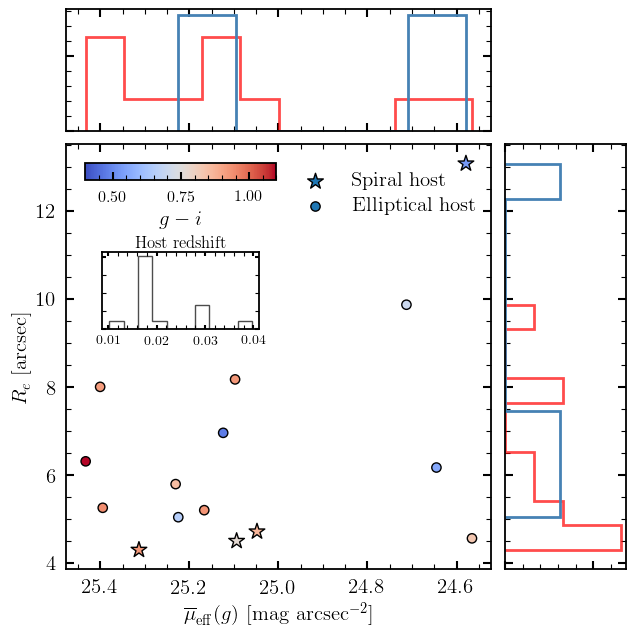

In [97]:
# start with a square Figure
fig = plt.figure(figsize=(7, 7))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.set_yticklabels([])
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.set_xticklabels([])

flag = (selected_cat['host_spiral'] == 1)
sct = ax.scatter(
    SB_g[flag],
    R_e[flag],
    c=(selected_cat['mag'][:, 0] - selected_cat['mag'][:, 2])[flag],
    vmin=0.4, vmax=1.1,
    cmap='coolwarm',
    marker='*',
    edgecolor='k',
    s=140,
    alpha=1,
    label='Spiral host'
    )

sct = ax.scatter(
    SB_g[~flag],
    R_e[~flag],
    c=(selected_cat['mag'][:, 0] - selected_cat['mag'][:, 2])[~flag],
    vmin=0.4, vmax=1.1,
    cmap='coolwarm',
    edgecolor='k',
    s=45,
    alpha=1,
    label='Elliptical host'
    )

ax.legend(loc='upper right', bbox_to_anchor=(1.03, 1))

cax = inset_axes(ax, width="45%", height="4%", 
                 loc='upper left', bbox_to_anchor=(0.02, -0.02, 1, 1),
                 bbox_transform=ax.transAxes) 
plt.colorbar(sct, cax=cax, label='$g-i$',
             orientation='horizontal')
cax.tick_params(labelsize=11.5)

# ax.set_xlim(29, 24)
# ax.set_ylim(1.6, 14)
ax.invert_xaxis()
ax.set_xlabel(r'$\overline{\mu}_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$R_e\ [\rm arcsec]$')

ax_histx.hist(SB_g[red], lw=2,
              histtype='step', density=True, color='r', 
              alpha=0.7, label='$g-i > 0.7$')
ax_histx.hist(SB_g[~red], lw=2,
              histtype='step', density=True, color='steelblue', label='$g-i < 0.7$')
ax_histy.hist(R_e[red], lw=2,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.7)
ax_histy.hist(R_e[~red], lw=2,
              histtype='step', density=True, orientation='horizontal', color='steelblue')
# ax_histy.set_xscale('log')

# show redshift
cax2 = inset_axes(ax, width='37%', height='18%', 
                  loc='upper left', 
                  bbox_to_anchor=(0.06, -0.23, 1, 1),
                  bbox_transform=ax.transAxes)
cax2.hist(selected_cat['host_z'], histtype='step', density=True, color='k', alpha=0.7)
cax2.set_title('Host redshift', fontsize=12, pad=3)
cax2.set_yticklabels([])
cax2.set_xticks([0.01, 0.02, 0.03, 0.04])
cax2.tick_params(axis='both', which='both', length=3, labelsize=10, pad=4)

# plt.savefig('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/sample_summary.png')

In [98]:
selected_cat.write('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/udg_sample.fits', overwrite=True)

##### Write to Tex

In [99]:
tex_table = hstack([selected_cat[['viz-id', 'ra', 'dec']], 
        Column(data=selected_cat['rhalf_spergel'] * 0.168, name=r'$R_e$'),
        Column(data=selected_cat['SB_eff_avg'][:, 0], name=r'$\overline{\mu}_e(g)$'), 
        Column(data=selected_cat['mag'][:, 0], name=r'$g$'),
        Column(data=selected_cat['mag'][:, 0] - selected_cat['mag'][:, 2], name=r'$g-i$'),
        Column(data=selected_cat['host_z'], name=r'$z_{\mathrm{host}}$'),
        Column(data=selected_cat['dist_to_host_rvir'], name=r'$D_{\rm host}$'),
        Column(data=['S' if t == 1 else 'E' for t in selected_cat['host_spiral']], name='Host type')],
      )
tex_table.rename_column('viz-id', 'ID')
coords = SkyCoord(selected_cat['ra'], selected_cat['dec'], unit='deg')
tex_table['ra'] = (coords.ra / 15).to_string(sep=':', precision=0, fields=3)
tex_table['ra'] = ['0' + t if len(t) == 7 else t for t in tex_table['ra']]
tex_table['dec'] = np.array([f'+{t:.4f}' if t > 0 else f'{t:.4f}' for t in tex_table['dec']])
tex_table.rename_column('ra', 'R.A.')
tex_table.rename_column('dec', 'Dec.')

tex_table[r'$R_e$'] = [f'{t:.2f}' for t in tex_table[r'$R_e$']]
tex_table[r'$g$'] = [f'{t:.2f}' for t in tex_table[r'$g$']]
tex_table[r'$g-i$'] = [f'{t:.2f}' for t in tex_table[r'$g-i$']]
tex_table[r'$\overline{\mu}_e(g)$'] = [f'{t:.2f}' for t in tex_table[r'$\overline{\mu}_e(g)$']]
tex_table[r'$z_{\mathrm{host}}$'] = [f'{t:.4f}' for t in tex_table[r'$z_{\mathrm{host}}$']]
tex_table[r'$D_{\rm host}$'] = [f'{t:.2f}' for t in tex_table[r'$D_{\rm host}$']]

In [100]:
from astropy.io import ascii

In [101]:
selected_id

array([75619, 27795, 86113, 67181, 69381, 65780, 29808, 79982, 30269,
       14216, 81835, 21112, 85963, 73208, 75450])

In [102]:
ascii.write(tex_table, 
            Writer=ascii.Latex, 
               latexdict={'preamble': r'\begin{center}',
                       'tablefoot': r'\end{center}',
                       'tabletype': 'table*',
                          'units': {r'$R_e$': '(arcsec)', 
                                    r'$\overline{\mu_e}(g)$': r'(mag arcsec$^{-2}$)',
                                    r'$g$': '(mag)',
                                    r'$g-i$': '(mag)',
                                    r'$D_{\rm host}$': "($R_{\mathrm{vir}}$)"}
                         })

\begin{table*}
\begin{center}
\begin{tabular}{cccccccccc}
ID & R.A. & Dec. & $R_e$ & $\overline{\mu}_e(g)$ & $g$ & $g-i$ & $z_{\mathrm{host}}$ & $D_{\rm host}$ & Host type \\
 &  &  & (arcsec) &  & (mag) & (mag) &  & ($R_{\mathrm{vir}}$) &  \\
75619 & 01:07:24 & -0.6802 & 4.56 & 24.57 & 19.27 & 0.83 & 0.0177 & 0.35 & E \\
27795 & 22:56:25 & -1.2076 & 13.07 & 24.58 & 17.00 & 0.53 & 0.0103 & 0.87 & S \\
86113 & 23:30:43 & +0.2328 & 6.17 & 24.65 & 18.70 & 0.56 & 0.0172 & 0.50 & E \\
67181 & 23:21:26 & +1.8713 & 9.87 & 24.71 & 17.75 & 0.71 & 0.0296 & 0.87 & E \\
69381 & 01:56:29 & -4.5307 & 4.72 & 25.05 & 19.68 & 0.87 & 0.0177 & 0.20 & S \\
65780 & 02:23:01 & -1.8268 & 4.50 & 25.09 & 19.83 & 0.77 & 0.0194 & 0.52 & S \\
29808 & 01:07:27 & -0.6829 & 8.17 & 25.10 & 18.54 & 0.93 & 0.0177 & 0.39 & E \\
79982 & 23:05:00 & +1.8339 & 6.96 & 25.12 & 18.92 & 0.48 & 0.0171 & 0.86 & E \\
30269 & 01:03:30 & -0.6638 & 5.20 & 25.17 & 19.59 & 0.93 & 0.0179 & 0.85 & E \\
14216 & 01:55:50 & -2.5690 & 5.04 &

In [103]:
gal1 = selected_cat[selected_cat['viz-id'] == 75619]

In [104]:
gal2 = selected_cat[selected_cat['viz-id'] == 29808]

In [105]:
gal1_coord = SkyCoord(gal1['ra'], gal1['dec'], unit='deg')
gal2_coord = SkyCoord(gal2['ra'], gal2['dec'], unit='deg')

In [106]:
gal1_coord.separation(gal2_coord)

<Angle [0.01149488] deg>

In [ ]:
41.4

In [110]:
gal1['host_ang_diam_dist'].data * 41.4 / 206265 * 1000

array([15.38789361])

In [114]:
(13*u.hourangle + 2 * u.arcmin + 16 * u.arcsec).to(u.hourangle).to(u.deg)

<Quantity 195.03777778 deg>

In [116]:
(13 + 2 / 60 + 16 / 3600) * 15

195.56666666666666

In [115]:
(28 * u.deg + 57 * u.arcmin + 17 * u.arcsec).to(u.deg)

<Quantity 28.95472222 deg>

##### Exp time

In [122]:
def calc_exp(SB):
    return 10**(0.4 * (SB - 24.5)) * (10 / 6.5)**2 * (0.3/0.2) * 20 * u.min

$$t_{LDSS3} / t_{LRIS} = (D_{m} / D_{k})^{-2} \cdot (\epsilon_{m} / \epsilon_{k})^{-1} \cdot 10^{0.4 (\mu - 24.5)}$$

$$t_{LDSS3} / t_{LRIS} = (6.5 / 10)^{-2} \cdot (0.1 / 0.3)^{-1} \cdot 10^{0.4 (\mu - 24.5)}$$

In [123]:
calc_exp(24.5).to(u.hour)

<Quantity 1.18343195 h>

In [151]:
calc_exp(25.5).to(u.hour)

<Quantity 2.97264666 h>

In [158]:
(selected_cat['g-i'] < 0.75).sum()

5

In [153]:
exptime = calc_exp(selected_cat['SB_eff_avg_g']).to(u.hour)
exptime[selected_cat['g-i'] < 0.75] = 0.5 * u.hour

In [154]:
exptime

<Quantity [1.25678179, 0.5       , 0.5       , 0.5       , 1.96054604,
           2.04492744, 2.05142035, 0.5       , 2.18646428, 0.5       ,
           2.31985537, 2.50269111, 2.69731946, 2.71176347, 2.79421843] h>

In [155]:
exptime.sum()

<Quantity 25.02598773 h>

In [149]:
np.array([3968, 3933]) * (1 + 0.04)

array([4126.72, 4090.32])

In [150]:
10800 / 3600

3.0

In [125]:
300000 / 450

666.6666666666666

In [128]:
1 / 509 * 300000 / 2.355

250.27217098594718

In [129]:
1900 / 5

380.0

In [135]:
R = 4100 * 0.75 / 5
300000 / R / 2.355

207.13582932007665

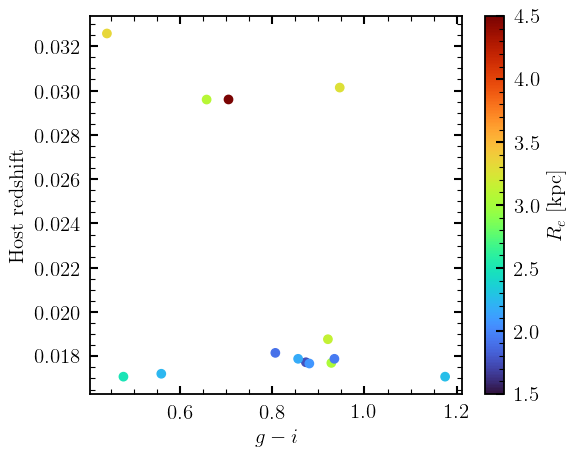

In [273]:
plt.scatter(cat['mag'][:, 0] - cat['mag'][:, 2], 
            cat['host_z'], 
            c=cat['rhalf_circularized_phys'], vmin=1.5, vmax=4.5)
plt.xlabel('$g-i$')
plt.ylabel('Host redshift')
plt.colorbar(label='$R_e$ [kpc]')

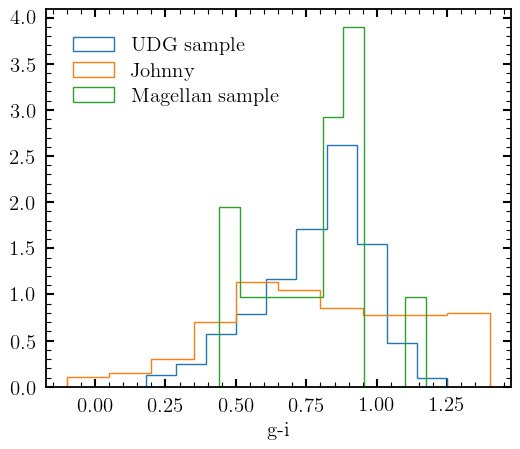

In [274]:
johnny = Table.read('./Catalog/Greco_S18A_lsbg.fits')
plt.hist(udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2], histtype='step', density=True, label='UDG sample')
plt.hist(johnny['g-i'], histtype='step', density=True, label='Johnny')
plt.hist(cat['mag'][:, 0] - cat['mag'][:, 2], density=True, histtype='step', label='Magellan sample')
plt.xlabel('g-i')
plt.legend(loc='upper left')

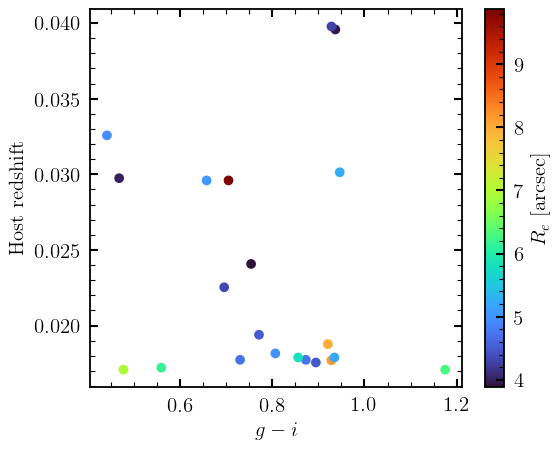

In [245]:
plt.scatter(cat['mag'][:, 0] - cat['mag'][:, 2], 
            cat['host_z'], 
            c=cat['rhalf_spergel'] * 0.168)
plt.xlabel('$g-i$')
plt.ylabel('Host redshift')
plt.colorbar(label='$R_e$ [arcsec]')

In [196]:
hstack([cat[['viz-id', 'ra', 'dec']], 
        Column(data=np.round(cat['rhalf_spergel'] * 0.168, 2), name='rhalf_'),
        Column(data=np.round(cat['SB_eff_avg'][:, 0], 2), name='SB_eff_avg_g'), 
        Column(data=np.round(cat['mag'][:, 0], 2), name='g_mag'),
        Column(data=np.round(cat['mag'][:, 0] - cat['mag'][:, 2], 2), name='g-i'),
       Column(data=np.round(cat['dist_to_host_rvir'], 2), name='dist2host_rvir')]
      ).write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/udg_cat_latex.tex', 
    format='ascii.latex')

In [197]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

In [199]:
from astropy.coordinates import SkyCoord
from astroplan import FixedTarget
from astroplan import Observer
from astroplan.plots import plot_airmass 
observer = Observer.at_site('Las Campanas Observatory')

In [235]:
objs = []
for i in range(15):
    coord = SkyCoord(cat['ra'][i], cat['dec'][i], unit='deg')
#     obj = FixedTarget(name=str(cat['viz-id'][i]), coord=coord)
    obj = FixedTarget(name=None, coord=coord)
    objs.append(obj)

No handles with labels found to put in legend.


Text(0.5, 1.0, '2022-09-15 02:00:00.000')

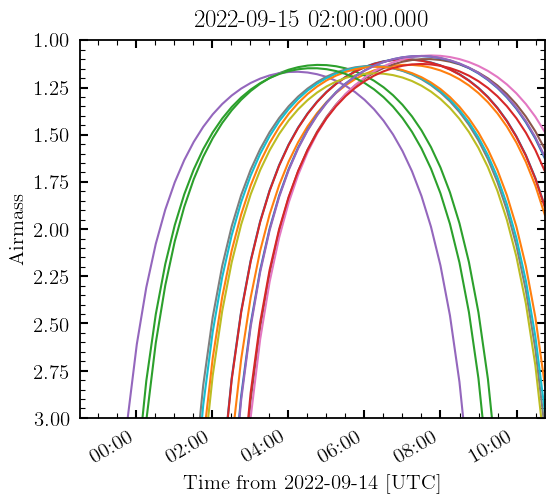

In [243]:
time = Time('2022-09-15 02:00')
sunset_time = observer.sun_set_time(time, which='nearest')
sunrise_time = observer.sun_rise_time(time, which='nearest')

observe_time = sunset_time + np.linspace(0, (sunrise_time - sunset_time).to(u.hour).value, 50) * u.hour

for i in range(15):
    plot_airmass(objs[i], observer, observe_time, )
# plot_airmass(objs[1], observer, observe_time)
# plot_airmass(objs[2], observer, observe_time)

plt.legend(shadow=True, loc=2)
plt.title(time)

No handles with labels found to put in legend.


Text(0.5, 1.0, '2022-11-15 02:00:00.000')

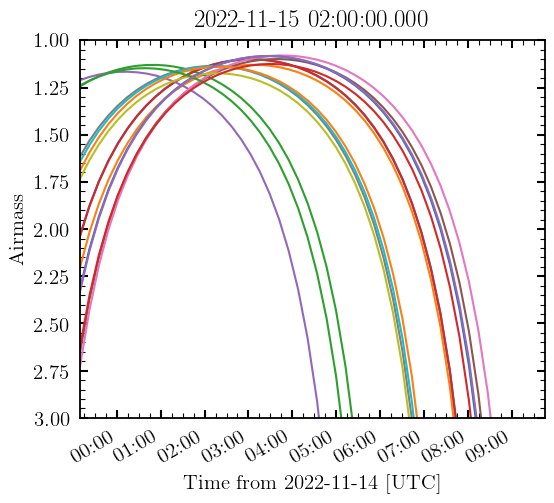

In [242]:
time = Time('2022-11-15 02:00')
sunset_time = observer.sun_set_time(time, which='nearest')
sunrise_time = observer.sun_rise_time(time, which='nearest')

observe_time = sunset_time + np.linspace(0, (sunrise_time - sunset_time).to(u.hour).value, 50) * u.hour

for i in range(15):
    plot_airmass(objs[i], observer, observe_time, )
# plot_airmass(objs[1], observer, observe_time)
# plot_airmass(objs[2], observer, observe_time)

plt.legend(shadow=True, loc=2)
plt.title(time)